*In this notebook:*<br>
CRISP-DM: Step 1, Step 2, Step 5<br>
**Answering the Business Questions** form notebook 01 and thereby **Understand the Data**
___

In [1]:
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

# Result from notebook 01
import CategoricalPrep as cp

# Auxilliary functions
from ExploreData import sort_mean, index_by_key
from TransformData import date_transform


%matplotlib inline
sns.set_theme()

In [2]:
df_listings = pd.read_csv('./data/listings.csv')

Up to now the listings data has been explored thoroughly. These learnings are now  stored in the functions below.

1. Some columns don't seem to be relevant
2. And some columns are easier to handle when transformed into a different type or form

In [3]:
# Drop columns which are irrelevant 
listings_drop_col = cp.drop_columns_analyze(df_listings)

# Transform categorical columns
listings_drop_trans = cp.transform_columns(listings_drop_col)

In [4]:
# Show all columns
listings_drop_trans.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 124 columns):
 #    Column                                Dtype  
---   ------                                -----  
 0    id                                    int64  
 1    name                                  object 
 2    summary                               object 
 3    space                                 object 
 4    description                           object 
 5    neighborhood_overview                 object 
 6    notes                                 object 
 7    transit                               object 
 8    host_id                               int64  
 9    host_about                            object 
 10   host_response_time                    float64
 11   host_response_rate                    float64
 12   host_acceptance_rate                  float64
 13   host_is_superhost                     float64
 14   host_neighbourhood                    object 
 15   ho

# The Host Perspective
At this point we can use the data to answer the questions we already introduced in notebook 01.<br>
Taking the perspective of a host on Airbnb we want to investigate: <br>

1. Which parameters influence a listings price?
1. What parameter can the host use to improve price and value?
1. Can we make a good price estimation for a new offer to assist a (new) host?


## 1. The Price and Its Influences 
*What influences Airbnb-prices in Seattle?*

To answer that question, we calculate the *correlation-matrix* for the data-set and identify the main correlations for the `price`.<br>

**How to choose the main correlations?**<br>
At this moment it is a matter of trial and error. But after some exploration it seems that correlations and anti-correlations with an absolute value higher than 0.1 appear to be interesting.

In [5]:
# The correlation matrix for the entire data set
listings_corr = listings_drop_trans.corr()

<AxesSubplot:>

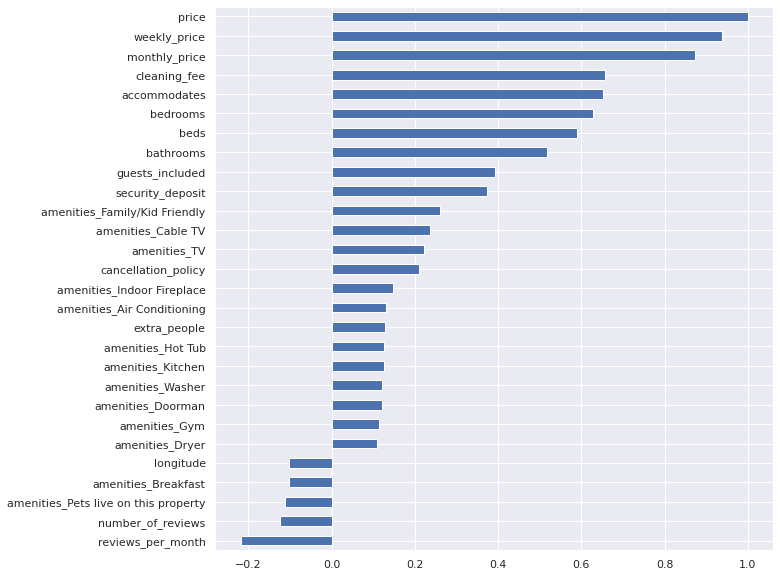

In [6]:
# Main correlations for the price
price_feature = 'price'
sensitivity = 0.1

corr_price = listings_corr[price_feature].loc[
    listings_corr[price_feature].abs()>sensitivity
    ]

# Visualize the correlations
corr_price.sort_values().plot(kind='barh', figsize=(10,10))

<AxesSubplot:>

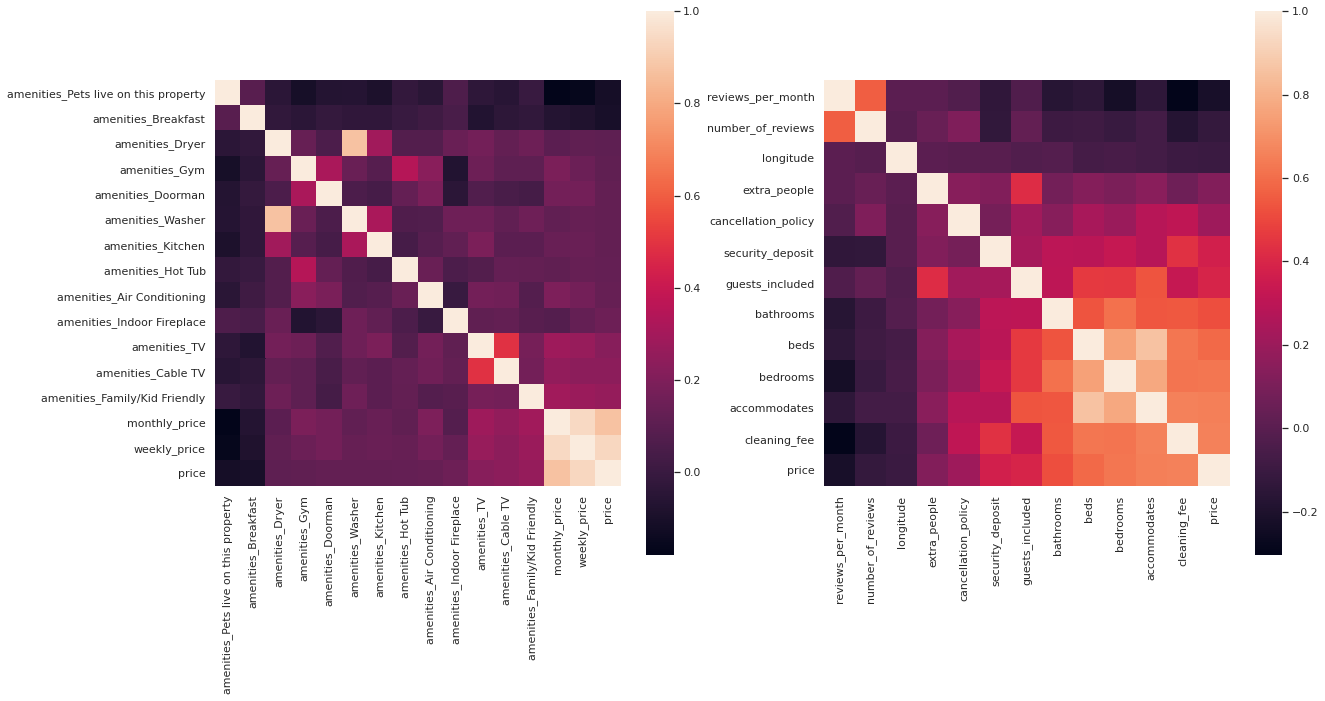

In [7]:
# Sort correlating features into two groups
price_corr_amenities = index_by_key( corr_price, ['amenities', 'price'], False)
price_corr_rest = corr_price.index.difference(price_corr_amenities)


# Visualize the correlations inside the groups
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Amenities correlation matrix
sns.heatmap(
    listings_drop_trans[price_corr_amenities].corr().sort_values(
        price_feature).sort_values(price_feature, axis=1
        ),
    linewidths=0, annot=False, square=True,  ax=ax1
    )
# Everything else
sns.heatmap(
    listings_drop_trans[list(price_corr_rest)+['price']].corr().sort_values(
        price_feature).sort_values(price_feature, axis=1
        ),
    linewidths=0, annot=False, square=True,  ax=ax2
    )

### What we can see:

* First thing to notice is: The `price` correlates strongly with related fees like `cleaning_fee`, `guests_included`,  and `security_deposit`.
* A second strong relation comes with the number of `bedrooms`, `beds`, `bathrooms` - features which state something about the size and status of the property.
* There are correlations among all property and price related features. One can see that in the color pattern of the right grit.
* The number of people a property `accommodates` also scales with the `price`.

* Many `amenities` correlate or anti-correlate with the `price`. The top ones: family/kid friendliness, cable-TV and TV, Indoor fireplace and air conditioning.<br>
    Amenities also correlate among each other.
* The price is negatively correlated with the number of reviews and the reviews per month, which opens some questions:<br>
    Assuming the number of reviews is comparable to the number of bookings - are properties with a high price booked less frequently?
    
**In conclusion:** The price depends mainly on the the properties size, but can be influenced by interior, facilities or service provided by the host.




## 2. How Can a Host Improve a Properties Price and Value?
Correlations for the `price` show high values for room counts and the number of people accommodated.<br>
That makes sens. But it is not entirely within the power of a host to change the number of bedrooms or bathrooms of a property.<br>
Maybe the price can be scaled according to the properties size to make it more comparable.<br>


The plot below shows the influence between *bedrooms* *accommodates* and *price*.<br>
There is an obvious relationship between the number of people who can stay at a property and the number of bedrooms offered.<br>
The price also seems to increase with these two parameters, but not strictly. It is not obvious which parameter is better suited to scale the price.

**Lets test two new different price-features**:<br> `bedroom_price` and `head_price`

<AxesSubplot:xlabel='bedrooms', ylabel='accommodates'>

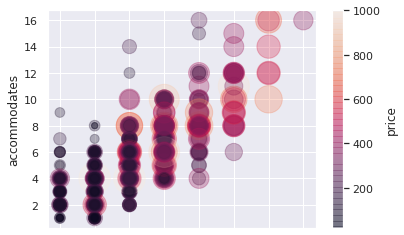

In [8]:
# A scatter-plot for accommodates and bedrooms
listings_drop_trans.plot(
    kind='scatter', x='bedrooms',
    y='accommodates', s='price',
    legend= True, c= 'price', colormap= 'rocket',  alpha=0.3
    )  

In [9]:
# New price features: Price per bedroom and price per person
listings_drop_trans['bedroom_price'] = listings_drop_trans[
    'price']/listings_drop_trans['bedrooms'].apply(lambda x: 1 if x==0 else x)
listings_drop_trans['head_price'] = listings_drop_trans[
    'price']/listings_drop_trans['accommodates']

# Remove the weekly and monthly price to focus on the dayly price.
# But keep the information that they were offered.
listings_drop_trans['has_weekly_price'] = listings_drop_trans[
    'weekly_price'].notnull().astype('int')
listings_drop_trans['has_monthly_price'] = listings_drop_trans[
    'monthly_price'].notnull().astype('int')
listings_drop_trans = listings_drop_trans.drop(
    columns=['monthly_price','weekly_price'], axis=1
    )

# Update the correlation matrix
listings_corr = listings_drop_trans.corr()

The box-plot below shows a significant difference between the `bedroom_price` and `head_price`.<br>
Both are less smeared than the price but `bedroom_price` has more outliers than `head_price`.<br>
The comparison in correlations, following below, goes into detail about the differences.

<AxesSubplot:>

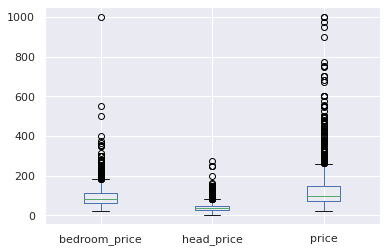

In [10]:
# Compare new price-features distributions with the price in box-plot
listings_drop_trans[['bedroom_price', 'head_price', 'price']].plot(kind='box')

<AxesSubplot:>

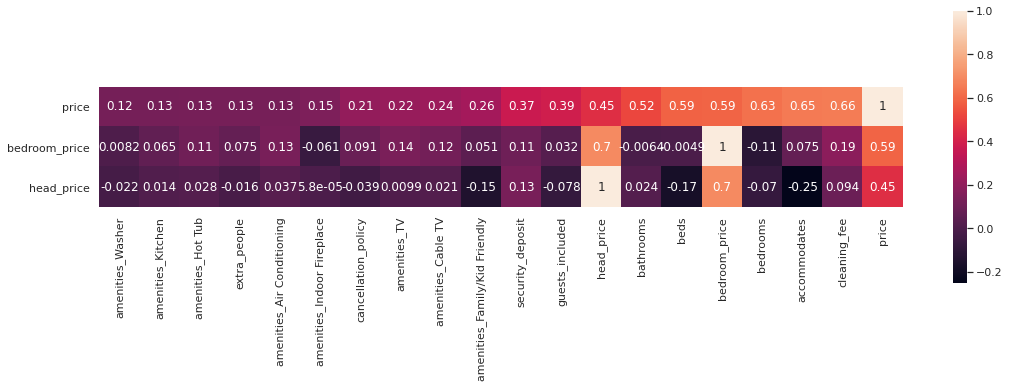

In [11]:
# Compare correlations for different price features:

columns = ['price', 'bedroom_price', 'head_price']
# Pick the 20 features showing the highes correlation with the price
attributes = listings_corr['price'].nlargest(20).index

# Isolate the correlations for the designated price columns
price_corr = listings_corr.loc[attributes, columns].sort_values('price').T

# Visualice the result
f, ax = plt.subplots(figsize=(18, 5))
sns.heatmap(price_corr, linewidths=0, annot=True, square=True,  ax=ax)

`bedroom_price` is probably the best suited measure.<br>
It keeps some correlation with features a host can actually influence and have a certain *hotel-character*.<br>
Whereas the head-price is even anti-correlated with family friendliness. 

**Lets look at the bedroom price in detail:**
* It has correlations with a group of `amenities`
* Some `review_scores` correlate with the `bedroom_price`
* And some general attributes are in the set too

This time the `sensitivity` to choose interesting correlations is set a bit lower to get a larger picture.

<AxesSubplot:>

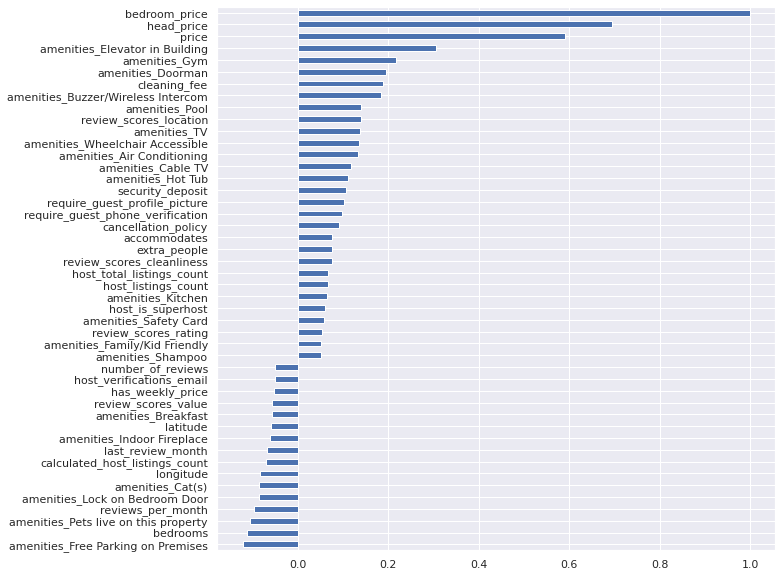

In [12]:
# Isolate the main correlations for the bedroom_price
price_feature = 'bedroom_price'
sensitivity = 0.05
corr_price = listings_corr[price_feature].loc[listings_corr[price_feature].abs()>sensitivity]

# Visualize the result
corr_price.sort_values().plot(kind='barh', figsize=(10,10))

In [13]:
# Sort correlating features into three groups
price_corr_reviews = index_by_key( corr_price, ['review', 'price'], False)
price_corr_amenities = index_by_key( corr_price, ['amenities', 'price'], False)
price_corr_rest = corr_price.index.difference(price_corr_reviews).difference(price_corr_amenities)

<AxesSubplot:>

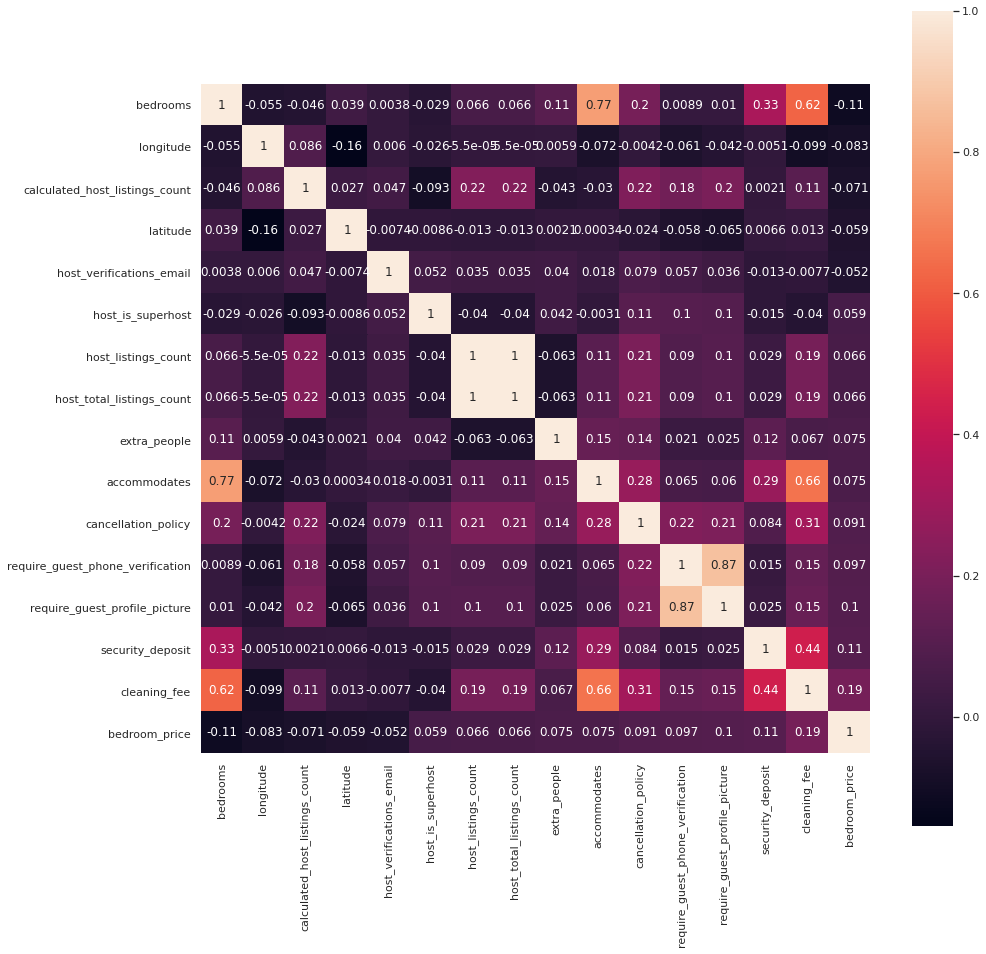

In [14]:
# Plot the correlations for everything exept amenites and review-featurs
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(
    listings_drop_trans[
        list(price_corr_rest)+['bedroom_price']
        ].corr().sort_values(price_feature).sort_values(price_feature, axis=1),
    linewidths=0,
    annot=True,
    square=True,
    ax=ax
    )


<AxesSubplot:xlabel='cancellation_policy'>

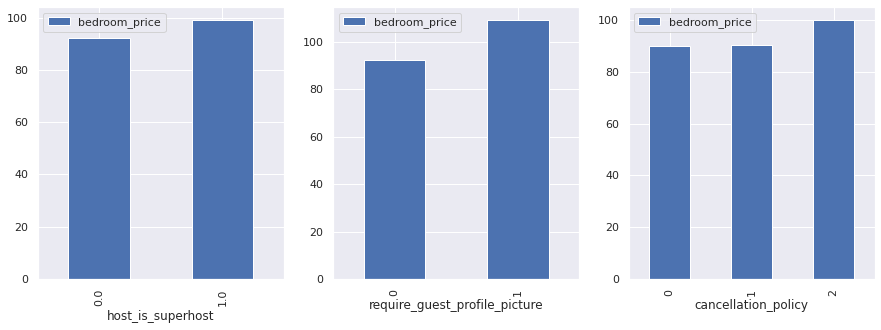

In [15]:
# Plot details about features with high correlation
f, ax = plt.subplots(1, 3, figsize=(15,5))

sort_mean(listings_drop_trans, 'host_is_superhost',
          'bedroom_price', True).plot(kind='bar', ax=ax[0])
sort_mean(listings_drop_trans, 'require_guest_profile_picture',
          'bedroom_price', True).plot(kind='bar', ax=ax[1])
sort_mean(listings_drop_trans, 'cancellation_policy',
          'bedroom_price', True).plot(kind='bar', ax=ax[2])

**The host characteristics:**
It seems that the experienced host can set the price a little higher.<br>
One can see that in the price margin between *host* and *super_host*.<br>

**Requirements and Conditions:**
Both a strict cancellation policy and a required guest profile picture come with a higher mean price.<br>
Those are probably characteristics of a high priced offer. They are not features increasing a properties values.

array([[<AxesSubplot:xlabel='cleaning_fee', ylabel='cleaning_fee'>,
        <AxesSubplot:xlabel='security_deposit', ylabel='cleaning_fee'>,
        <AxesSubplot:xlabel='extra_people', ylabel='cleaning_fee'>,
        <AxesSubplot:xlabel='bedroom_price', ylabel='cleaning_fee'>],
       [<AxesSubplot:xlabel='cleaning_fee', ylabel='security_deposit'>,
        <AxesSubplot:xlabel='security_deposit', ylabel='security_deposit'>,
        <AxesSubplot:xlabel='extra_people', ylabel='security_deposit'>,
        <AxesSubplot:xlabel='bedroom_price', ylabel='security_deposit'>],
       [<AxesSubplot:xlabel='cleaning_fee', ylabel='extra_people'>,
        <AxesSubplot:xlabel='security_deposit', ylabel='extra_people'>,
        <AxesSubplot:xlabel='extra_people', ylabel='extra_people'>,
        <AxesSubplot:xlabel='bedroom_price', ylabel='extra_people'>],
       [<AxesSubplot:xlabel='cleaning_fee', ylabel='bedroom_price'>,
        <AxesSubplot:xlabel='security_deposit', ylabel='bedroom_price'>,
        

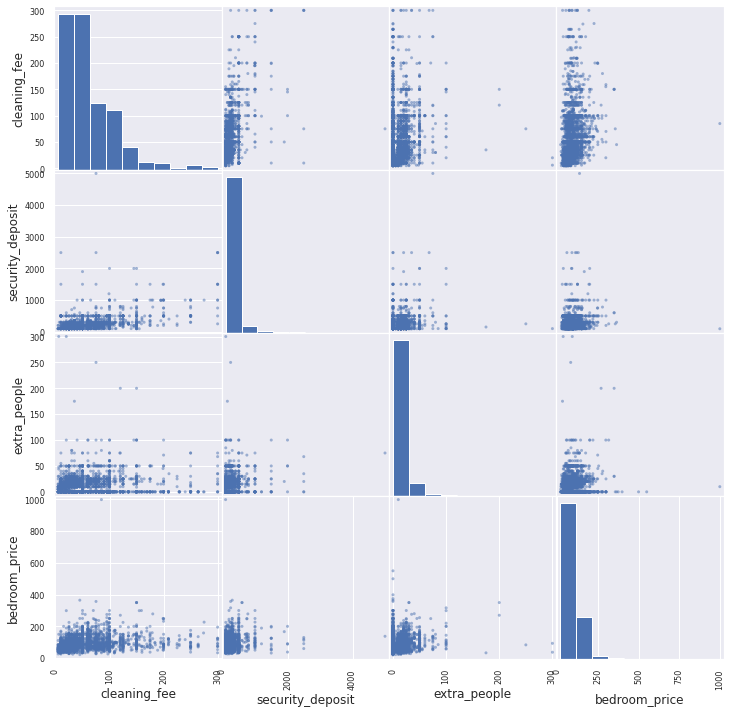

In [16]:
# How do currancy-features relate to the bedroom_price?
scatter_matrix(listings_drop_trans[
    ['cleaning_fee', 'security_deposit', 'extra_people', 'bedroom_price']
    ], figsize=(12,12))

<AxesSubplot:ylabel='security_deposit'>

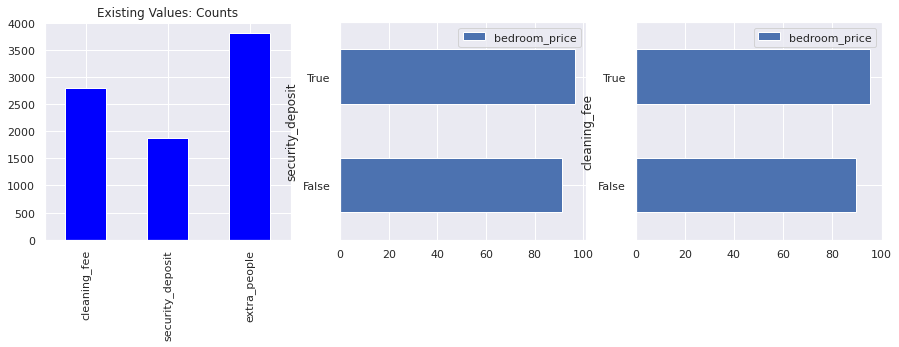

In [17]:
# Check for null-values in the correlating currency columns
df_nullfees = listings_drop_trans[
    ['cleaning_fee', 'security_deposit', 'extra_people']
    ].notnull()
df_price_nullfee = df_nullfees.join(listings_drop_trans['bedroom_price'])

# Plot the number of existing fees
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

df_nullfees.sum().plot(
    kind='bar',
    ax=ax1,
    title='Existing Values: Counts',
    color= 'blue'
    )
# Visualize the mean bedroom price with and without fees
sort_mean(df_price_nullfee, 'cleaning_fee', 'bedroom_price', True ).plot(
    kind='barh',
    ax=ax3
    )
sort_mean(df_price_nullfee, 'security_deposit', 'bedroom_price', True ).plot(
    kind='barh',
    ax=ax2
    )


**Fees**: Much like requirements and conditions, fees also seem to be something caused by a high valued offer and not the other way around.<br>
Nevertheless fees appear and increase together with a rising bedroom price.

<AxesSubplot:>

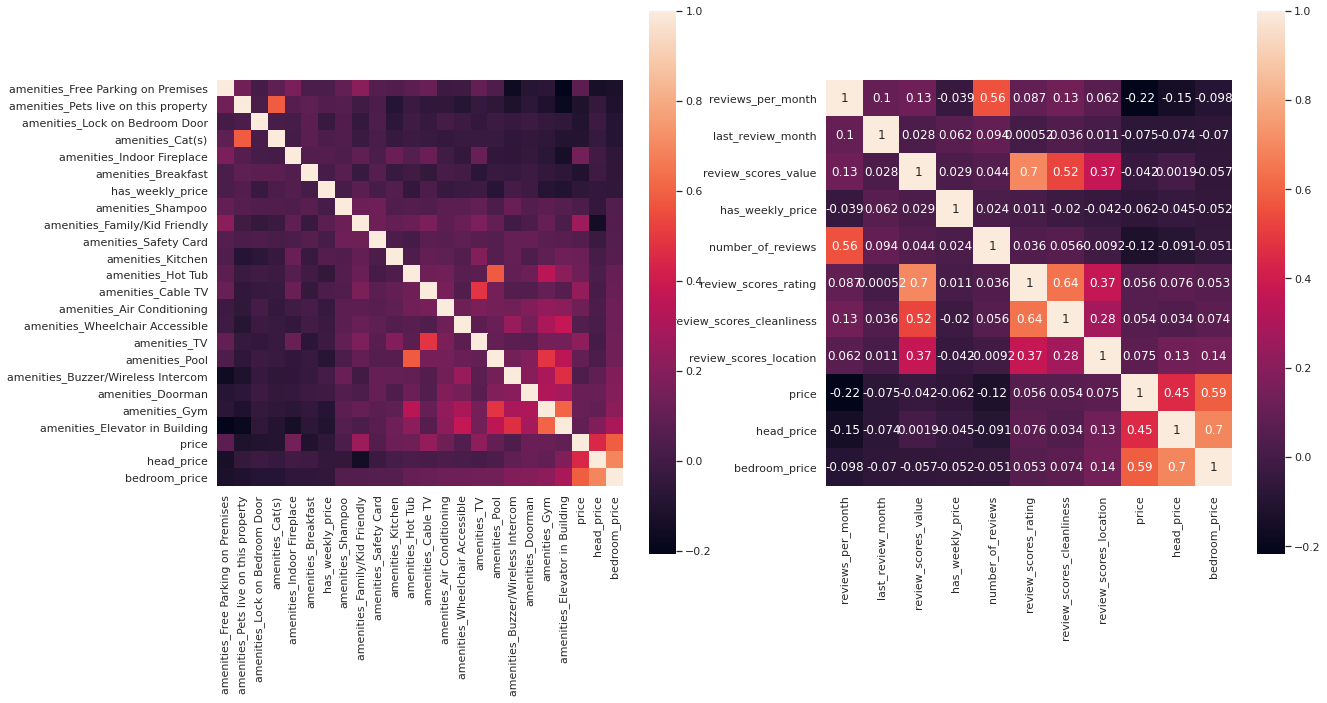

In [18]:
# Plot the correlation matrix for the remaining feature groups:
# amenities an review scores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

sns.heatmap(
    listings_drop_trans[price_corr_amenities].corr().sort_values(
        price_feature).sort_values(price_feature, axis=1),
    linewidths=0,
    annot=False,
    square=True,
    ax=ax1
    )
sns.heatmap(
    listings_drop_trans[price_corr_reviews].corr().sort_values(
        price_feature).sort_values(price_feature, axis=1),
    linewidths=0,
    annot=True,
    square=True,
    ax=ax2
    )

### 2.1 Can a Host Improve His/Her Offer By Supplying Certain Amenities?

<AxesSubplot:title={'center':'Correlation with Price per Bedroom'}>

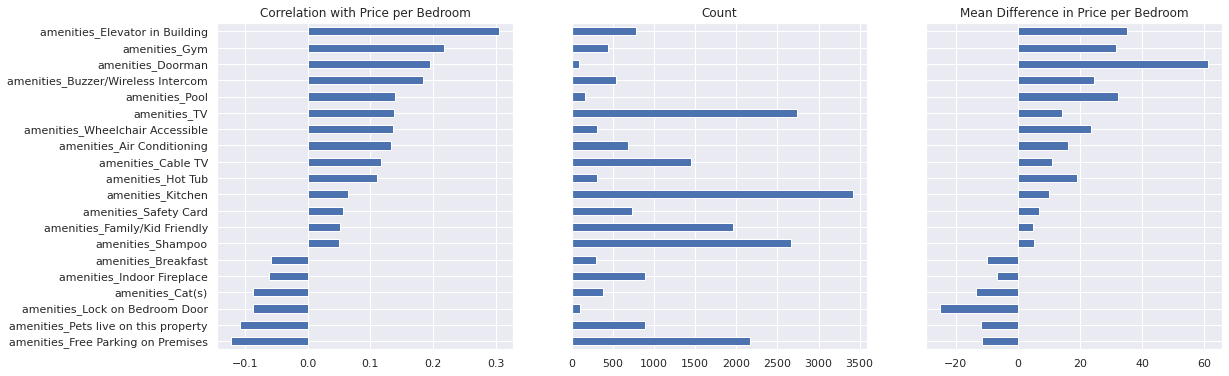

In [19]:
# Amenities above the sensitivity threshold
amenity_names = index_by_key( corr_price, ['amenities'], False)  
# How often are they offered?
amenity_counts = listings_drop_trans[amenity_names].sum()

# Find the mean bedroom_price with and without each amenity
difference_amenities = pd.DataFrame([], columns= [], index=[0,1])
for a in amenity_names:
    mean = sort_mean(listings_drop_trans, a, 'bedroom_price', True)
    difference_amenities[a] = mean['bedroom_price']
difference_amenities = difference_amenities.T

# Calculate the mean price difference for each amenity
difference_amenities['delta'] = difference_amenities[1] \
                                - difference_amenities[0]
# Add the counts of each amenity in the data set to the data frame
difference_amenities['count'] = amenity_counts
# Add the bedroom_price correlation of each amenity in the data set
difference_amenities['corr'] = listings_corr.loc[amenity_names,
                                                'bedroom_price']

# Plot difference and count for each amenity
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6), sharey = True)

difference_amenities = difference_amenities.sort_values('corr')

difference_amenities['count'].plot(kind='barh', ax=ax2,
                                title='Count')
difference_amenities['delta'].plot(kind='barh', ax=ax3,
                                title='Mean Difference in Price per Bedroom')
difference_amenities['corr'].plot(kind='barh', ax=ax1,
                                title='Correlation with Price per Bedroom')


**The Offer:**
It seems that certain amenities make a big difference in the price.
Not all of them appear often in the data set. As a result the mean bedroom price has to be used with caution. A Doorman seems to come with a very high price but there are also very few properties witch actually have one. It is hard to say then, whether this is a general correlation or an outlier.<br>

Amenities improving the price and having more than 500 counts:<br>

* Safety Card
* Family friendliness
* TV and cable TV
* Buzzer/Intercom

Amenities improving the price which suggest a little more investment and or effort from the host:<br>

* Elevator
* Air conditioning
* A kitchen
* A hot tub
* Wheelchair accessibility

### 2.2 How Do Guest Reviews Influence the Price?

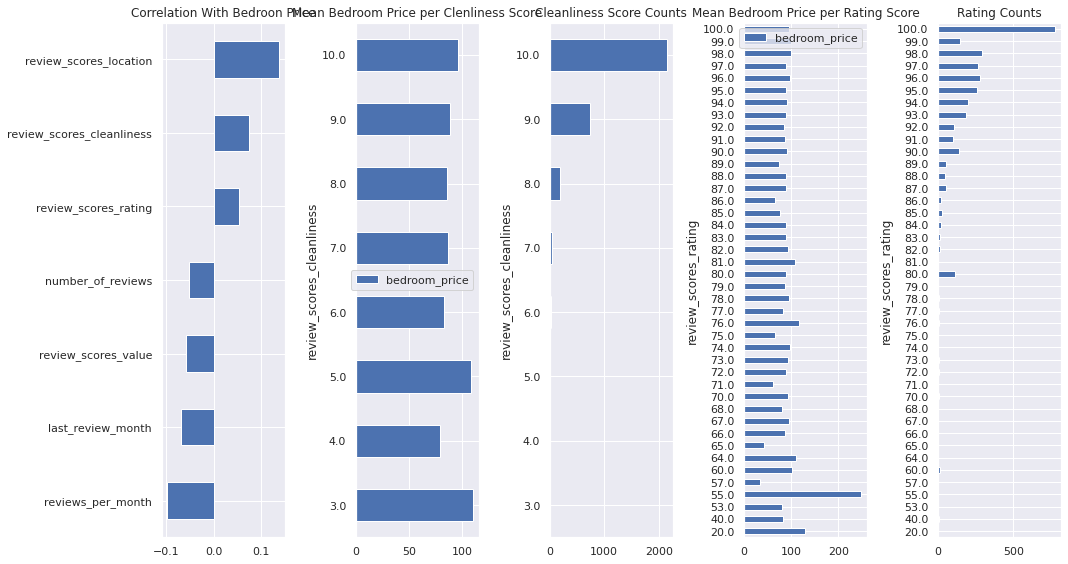

In [21]:
# Idendify review-features with price-correlation
review_names = index_by_key( corr_price, ['review'], False)

# Count listings per review scores
rating_counts = listings_drop_trans[['bedroom_price']].groupby(
    listings_drop_trans['review_scores_rating']).count()

cleanliness_counts = listings_drop_trans[['bedroom_price']].groupby(
    listings_drop_trans['review_scores_cleanliness']).count()

# Plot an overview over the correlating review scores
f, (ax1, ax2, ax5, ax3, ax4) = plt.subplots(1, 5, figsize=(15,8))

listings_corr.loc[review_names, 'bedroom_price'].sort_values().plot(
    kind='barh',
    ax=ax1,
    title='Correlation With Bedroon Price'
    )

sort_mean(listings_drop_trans, 'review_scores_cleanliness',
    'bedroom_price', True
    ).plot(
        kind='barh',
        ax=ax2, title='Mean Bedroom Price per Clenliness Score'
        )

sort_mean(listings_drop_trans, 'review_scores_rating',
    'bedroom_price', True
    ).plot(
        kind='barh',
        ax=ax3,
        title='Mean Bedroom Price per Rating Score'
        )

rating_counts.plot(kind='barh', ax=ax4, title='Rating Counts', legend=False)

cleanliness_counts.plot(kind='barh', ax=ax5,
                        title='Cleanliness Score Counts', legend=False)
f.tight_layout()


**Reputation:** The most interesting correlations are the cleanliness scores and ratings.<br>
The histograms for both show that the distributions are skewed to high values (positive evaluations).
Considering that, it is no surprise, the mean bedroom price per score is smoother for higher values. <br>
Unfortunately that makes the mean bedroom price plots rather useless.<br>
**But the scatter plots below definitely show a tendency for high priced properties to have higher scores.**

<AxesSubplot:xlabel='review_scores_rating', ylabel='bedroom_price'>

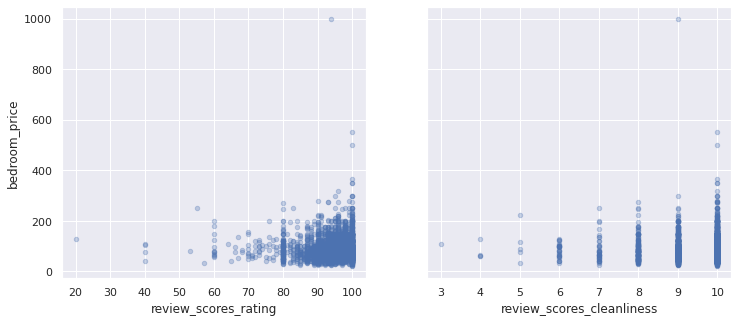

In [23]:
# Scatter plots
f, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

listings_drop_trans.plot(kind='scatter', x='review_scores_cleanliness',
                        y='bedroom_price', alpha=0.3, ax=ax2, c='C0')
listings_drop_trans.plot(kind='scatter', x='review_scores_rating',
                        y='bedroom_price', alpha=0.3, ax=ax1, c='C0')

Even the total listings price was anti correlated to the `reviews_per_month`.
And it still holds for the price per bedroom.<br>
The figure below shows the distributions and the joined distribution of the `bedroom_price` and the `reviews_per_month`. Both have an emphasis on lower values and one can see, the bedroom hast to cost well over 100$ to be really effected.<br>
But still that does not answer the question, do high priced offers just target guests who stay for longer intervals or are they less popular?


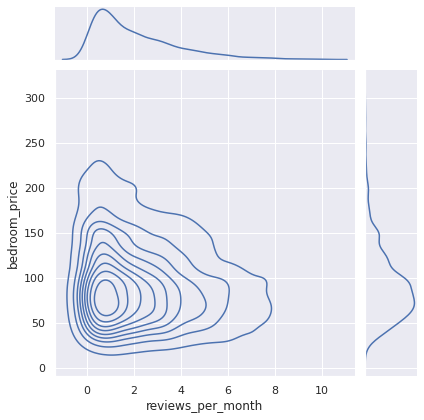

In [24]:
# Bedroom_price is anti-correlated to reviews per month:
# Display the relation between both features

# Restrict the data frame to the relevant plotting range
df_review_plott = listings_drop_trans[price_corr_reviews].loc[
    listings_drop_trans['bedroom_price']<300
].loc[
    listings_drop_trans['reviews_per_month']<=10
    ]

# Plot
sns.jointplot(
    x=df_review_plott['reviews_per_month'],
    y=df_review_plott['bedroom_price'],
    kind="kde"
    )


### 0. Other Influences On The Price
There are definitely more parameters influencing the price. But we are interested in those a host might try to influence.<br>
The review score correlations already showed, the location scores have a higher correlation than the review or cleanliness scores. But a host can not change much about the properties location.<br>

**Below are some examples of what else influences the price.**

<AxesSubplot:xlabel='room_type'>

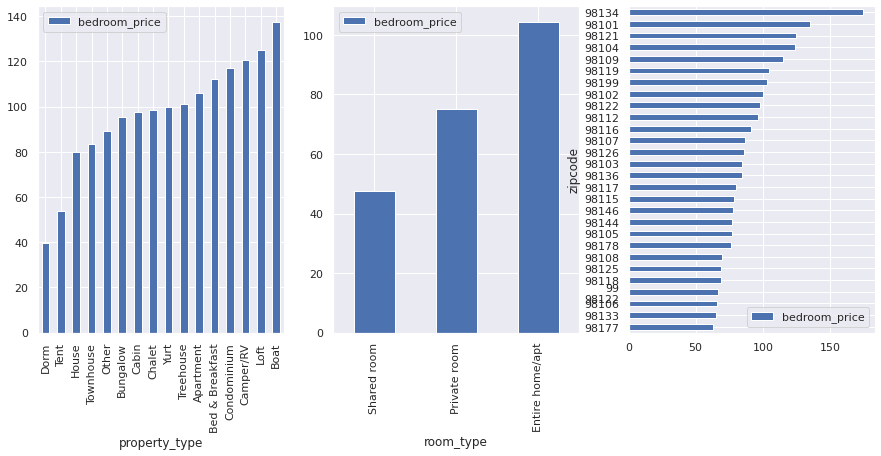

In [25]:
zipcode_to_price = sort_mean(listings_drop_trans, 'zipcode', 'bedroom_price')
property_to_price = sort_mean(listings_drop_trans, 'property_type',
                            'bedroom_price')
room_to_price = sort_mean(listings_drop_trans, 'room_type', 'bedroom_price')

# Visualize
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))

zipcode_to_price.plot(kind='barh', ax=ax3)
property_to_price.plot(kind='bar', ax=ax1)
room_to_price.plot(kind='bar', ax=ax2)

<AxesSubplot:xlabel='month'>

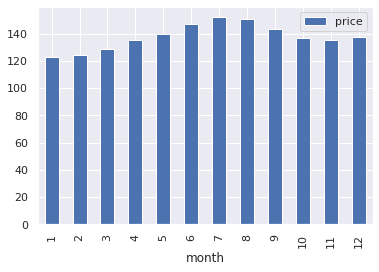

In [26]:
# Read calendar data to data frame
df_calendar = pd.read_csv('./data/calendar.csv')
# Price is a string type: convert to a float
df_calendar['price'] = df_calendar['price'].replace('[\$,]', '',
                                                    regex=True).astype(float)

# Transformnig the data calumns in df_calendar to date-type
# and split the date information into three columns
date_transform(df_calendar, 'date')

# Plot the mean price per month (in 2016)
price_month = sort_mean(df_calendar, 'month', 'price').sort_index()
price_month.plot(kind="bar")